In [230]:
!pip install openai
import openai

In [231]:
import os
from openai import OpenAI
import numpy as np
import matplotlib.pyplot as plt
import pandas as pdf

In [1]:
# read my key from file openai_key.txt
with open('../../keys/openai_gpt_siji.txt', 'r') as file:
    key = file.read().replace('\n', '')


In [250]:
client = OpenAI(
    # This is my API key, you should use your own
    api_key=key
)

def get_chat_completion(messages,client=client, model="gpt-3.5-turbo-0125"):
    # the cheapest model I could find; input $0.0005 / 1K tokens; output $0.0015 / 1K tokens
    chat_completion= client.chat.completions.create(
        messages=[
            {"role":"system","content":"You are a data scientist working on anomaly detection."},
             {
            "role": "user",
            "content": messages,
        }
            ],
        model=model,
        temperature=0,
        max_tokens=100,
        store=True,
    )
    return chat_completion

MODEL_LIST=["gpt-4o","gpt-4o-mini","gpt-4-turbo","gpt-3.5-turbo-0125"]


In [245]:
def print_response(response, debug=False):
    if debug:
        # print the tokens size
        print('total tokens:', response.usage.total_tokens, 'prompt tokens:', response.usage.prompt_tokens, 'completion_tokens tokens:', response.usage.completion_tokens)
    print(response.choices[0].message.content)
    

In [246]:
# create sine wave data
def sine_wave(n=100, freq=1, amp=1, phase=0):
    x = np.linspace(0, 1, n)
    y = amp * np.sin(2 * np.pi * freq * x + phase)
    return x, y

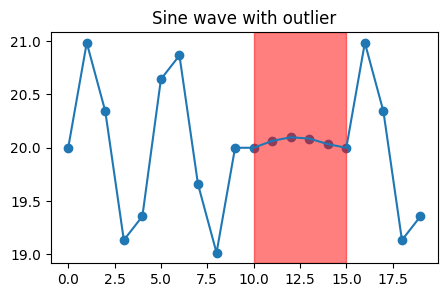

In [247]:
x,y1=sine_wave(n=10, freq=2, amp=1, phase=0)
y1=y1+20
x,y2=sine_wave(n=10, freq=10, amp=0.1, phase=0)
y2=y2+20
# concatenate the two sine waves
y=np.concatenate([y1,y2[:5],y1[:5]])
# y=y1
# y[6]=30
# set figure size
plt.figure(figsize=(5, 3))
# scatter plot
plt.plot(range(0,len(y)), y)
plt.scatter(range(0,len(y)), y)
plt.title("Sine wave with outlier")
# add vertical region to highlight the outlier
plt.axvspan(len(y1), len(y1)+5, color='red', alpha=0.5)

In [248]:
# use y as the dataset, format it as a string with 2 decimals
dataset = np.array2string(y, precision=2, separator=',',suppress_small=True)

prompt =f"""
You are a data scientist working on abnomaly detection.
The dataset you are working on is a collection of data from a sensor 
that measures the room temperature. 
Data: ```{dataset}```
Give the reason for the anomaly in less than 20 words.
Return the index and value of the anomalies in [index, value] format. 
"""

print(prompt )



You are a data scientist working on abnomaly detection.
The dataset you are working on is a collection of data from a sensor 
that measures the room temperature. 
Data: ```[20.  ,20.98,20.34,19.13,19.36,20.64,20.87,19.66,19.02,20.  ,20.  ,20.06,
 20.1 ,20.09,20.03,20.  ,20.98,20.34,19.13,19.36]```
Give the reason for the anomaly in less than 20 words.
Return the index and value of the anomalies in [index, value] format. 



In [249]:
response = get_chat_completion(prompt,model=MODEL_LIST[0])
print_response(response, debug=True)

total tokens: 212 prompt tokens: 175 completion_tokens tokens: 37
Reason: Sensor malfunction or environmental change.  
Anomalies: [[1, 20.98], [6, 20.87], [16, 20.98]]


In [195]:
# use y as the dataset, format it as a string with 2 decimals
dataset_example = np.array2string(y, precision=2, separator=',',suppress_small=True)
dataset_test = np.array2string((y+1)[1:], precision=2, separator=',',suppress_small=True)

prompt =f"""
The dataset is a collection of data from a sensor that measures the room temperature. 
Find the abnomaly as the example below
and return in [index1,index2,...] format. 
Example: Data: ```{dataset_example}``` Anomaly: [10,11,12,13,14]
Your turn: Data:  ```{dataset_test}``` Anomaly:
"""
print(prompt)


The dataset is a collection of data from a sensor that measures the room temperature. 
Find the abnomaly as the example below
and return in [index1,index2,...] format. 
Example: Data: ```[20.  ,20.98,20.34,19.13,19.36,20.64,20.87,19.66,19.02,20.  ,20.  ,20.06,
 20.1 ,20.09,20.03,20.  ,20.98,20.34,19.13,19.36]``` Anomaly: [10,11,12,13,14]
Your turn: Data:  ```[21.98,21.34,20.13,20.36,21.64,21.87,20.66,20.02,21.  ,21.  ,21.06,21.1 ,
 21.09,21.03,21.  ,21.98,21.34,20.13,20.36]``` Anomaly:



In [196]:
response = get_chat_completion(prompt,model=MODEL_LIST[1])
print_response(response, debug=True)

total tokens: 276 prompt tokens: 255 completion_tokens tokens: 21
[8, 9, 10, 11, 12, 13, 14]


In [207]:
prompt =f"""
Find the abnomaly as the example below
Example: Data: ```{dataset_example}``` Anomaly: [10,11,12,13,14]
Your turn: Data:  ```{dataset_test}``` Anomaly:
"""
from pydantic import BaseModel
class ADReponse(BaseModel):
    reason:str
    anomalies_index: list[str]
    
chat_completion= client.beta.chat.completions.parse(
    messages=[
        {"role":"system","content":"You are a data scientist working on abnomaly detection."},
            {
        "role": "user",
        "content": prompt,
    }
        ],
    model=MODEL_LIST[1],
    temperature=0,
    max_tokens=100,
    response_format=ADReponse,
    )


In [213]:
result=chat_completion.choices[0].message.parsed
print(result.reason)
anomaliy_index = result.anomalies_index
# parse the index of the anomalies into numpy array as integer
anomaliy_index = np.array(anomaliy_index)
# convert the index to integer from string
anomaliy_index = anomaliy_index.astype(int)
print(anomaliy_index)


The values from index 10 to 14 are significantly different from the surrounding values, indicating an anomaly.
[10 11 12 13 14]


In [215]:
# what is the model
print(response.model)

gpt-4o-2024-08-06


## chain of thought

In [217]:
from pydantic import BaseModel
from openai import OpenAI



class Step(BaseModel):
    explanation: str
    output: str

class MathReasoning(BaseModel):
    steps: list[Step]
    final_answer: str

completion = client.beta.chat.completions.parse(
    model=MODEL_LIST[1],
    messages=[
        {"role": "system", "content": "You are a helpful math tutor. Guide the user through the solution step by step."},
        {"role": "user", "content": "how can I solve 8x + 7 = -23"}
    ],
    response_format=MathReasoning,
)

math_reasoning = completion.choices[0].message.parsed

SyntaxError: positional argument follows keyword argument (3042263013.py, line 21)

In [199]:
math_reasoning

MathReasoning(steps=[Step(explanation='We want to isolate the term with x, so we first subtract 7 from both sides of the equation.', output='8x + 7 - 7 = -23 - 7'), Step(explanation='Simplifying the left side gives us 8x, and simplifying the right side gives us -30.', output='8x = -30'), Step(explanation='Now, we need to solve for x by dividing both sides of the equation by 8.', output='x = -30 / 8'), Step(explanation='Simplifying -30/8 by dividing both the numerator and the denominator by 2 gives us -15/4.', output='x = -15/4')], final_answer='x = -15/4')

In [216]:
completion.choices[0].message.refusal